In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold,TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from dateutil.relativedelta import relativedelta
from datetime import timedelta
import tqdm

import random
from collections import Counter,defaultdict

from copy import deepcopy
sns.set_theme(style="ticks")
# データを保存しているフォルダのディレクトリ指定
DATA_DIR = './data/'
OUTPUT_DIR = "output"

# データ読み込み

submission = pd.read_csv(os.path.join(DATA_DIR, 'sample_submit.csv'), header = None)

status_df = pd.read_csv(os.path.join(DATA_DIR, 'status.csv'))
tmp = status_df['year'].astype(str).str.cat(status_df['month'].astype(str), sep='/')
tmp = tmp.str.cat(status_df['day'].astype(str), sep='/')
#tmp = tmp.str.cat(status_df['hour'].astype(str), sep='/')
#status_df["date"] = pd.to_datetime(tmp,format='%Y/%m/%d/%H')
status_df["date"] = pd.to_datetime(tmp,format='%Y/%m/%d')


trip_df = pd.read_csv(os.path.join(DATA_DIR, 'trip.csv'))
trip_df["start_date"] = pd.to_datetime(trip_df.start_date)
trip_df["end_date"] = pd.to_datetime(trip_df.end_date)

weather_df = pd.read_csv(os.path.join(DATA_DIR, 'weather.csv'))
weather_df['date'] = pd.to_datetime(weather_df['date'])

station_df = pd.read_csv(os.path.join(DATA_DIR, 'station.csv'))

supply_df = pd.read_csv(os.path.join(DATA_DIR, "supply.csv"), index_col = 0)

In [98]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

def savefig(fig, to):
    to = os.path.join(OUTPUT_DIR, to + '.png')
    print('save to {}'.format(to))
    fig.tight_layout()
    fig.savefig(to, dpi=120)

In [12]:
supply_df["date"] = pd.to_datetime(supply_df["date"])

In [13]:
class AbstractBaseBlock:
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        raise NotImplementedError()

In [103]:
class ZeroBikeBlock(AbstractBaseBlock):
    def __init__(self):
        self.t = status_df.groupby(['station_id', 'date']).first()['bikes_available'].reset_index()

        #self.t = pd.DataFrame(np.repeat(self.t.values, 24, axis=0))
        self.t.columns = ['station_id', 'date', 'bikes_available_at0']
        
    def transform(self, input_df):
        #input_df['bikes_available_at0'] = self.t['bikes_available_at0']
        input_df = pd.merge(input_df, self.t, on = ["station_id", "date"], how = 'left')
        #input_df["bikes_available_at0_log"] = np.log1p(input_df.bikes_available_at0)

        #print(self.t)

        return input_df


In [192]:
class MergeBlock(AbstractBaseBlock):
    def transform(self, input_df):
        input_df = pd.merge(input_df, station_df[['station_id', 'city']], how = 'left')
        weather_df_col =  ["date", 'max_temperature', 'mean_temperature', 'min_temperature',
       'max_dew_point', 'mean_dew_point', 'min_dew_point', 'max_humidity',
       'mean_humidity', 'min_humidity', 'max_sea_level_pressure',
       'mean_sea_level_pressure', 'min_sea_level_pressure', 'max_visibility',
       'mean_visibility', 'min_visibility', 'max_wind_Speed',
       'mean_wind_speed', 'precipitation', 'cloud_cover',
       'wind_dir_degrees']
        input_df = pd.merge(input_df, weather_df[weather_df_col], how = 'left')
        # input_df = pd.merge(input_df, station_df[['station_id', 'lat', 'long', 'dock_count']], how = "left")
        input_df = pd.merge(input_df, station_df[['station_id', 'dock_count']], how = "left")

        #input_df = pd.merge(input_df, weather_df[['date', 'precipitation']], how = 'left')
        return input_df

class DateEncodingBlock(AbstractBaseBlock):
    def transform(self, input_df):
        input_df['week_num'] = input_df['date'].dt.weekday
        return input_df

In [193]:
class TripEncodingBlock(AbstractBaseBlock):
    def __init__(self):
        self._trip_df = trip_df.copy()
        self._trip_df.start_date  = self._trip_df.start_date + timedelta(days=1)
        self._trip_df["start_date_nt"] = self._trip_df.start_date.dt.date

        self._trip_df.end_date  = self._trip_df.end_date + timedelta(days=1)
        self._trip_df["end_date_nt"] = self._trip_df.end_date.dt.date
        self._trip_df["count"] = 0
        
        self._end = self._trip_df[["end_station_id",
                                   "end_date_nt",
                                   "count"]].groupby(["end_station_id", "end_date_nt"]).count().reset_index()
        self._start = self._trip_df[["start_station_id",
                                     "start_date_nt",
                                     "count"]].groupby(["start_station_id", "start_date_nt"]).count().reset_index()
        self._start = self._start.rename(columns = {"start_station_id": "station_id",
                                                    "start_date_nt": "date",
                                                   "count": "start_date_count"})
        self._end = self._end.rename(columns = {"end_station_id": "station_id",
                                                    "end_date_nt": "date",
                                                   "count": "end_date_count"})
        self._start.date = pd.to_datetime(self._start.date)
        self._end.date = pd.to_datetime(self._end.date)

        #print(self._start)
    def transform(self, input_df):
        input_df = pd.merge(input_df, self._start, how = "left", on = ["station_id", "date"])
        input_df = pd.merge(input_df, self._end, how = "left", on = ["station_id", "date"])

        #input_df = pd.merge(input_df, self._start, how = "left", on = [["station_id, date"]])

        return input_df

In [194]:
class EncodeCityBlock(AbstractBaseBlock):
    def fit(self, input_df):
        self._le = LabelEncoder()
        self._le.fit(input_df.city)
        return self.transform(input_df)

    def transform(self, input_df):
        input_df["city"] = self._le.transform(input_df["city"])
        return input_df

In [195]:
class DeleteBlock(AbstractBaseBlock):
    def __init__(self, columns):
        self._columns = columns

    def transform(self, input_df):
        col = input_df.columns
        for c in self._columns:
            if c in col:
                input_df = input_df.drop(c, axis = 1)
        return input_df

In [284]:
feature_add_blocks = [
    MergeBlock(),
    DateEncodingBlock(),
    # ZeroBikeBlock(),
    #TripEncodingBlock(),
    #EncodeCityBlock(),
    DeleteBlock(['supply', 'date', "station_id", "city", "dock_count"]),
]

feat_train_df = supply_df.copy()
 
for block in feature_add_blocks:
    with timer(prefix='fit {} '.format(block)):
        feat_train_df = block.fit(feat_train_df.copy())
feat_train_df.head()

fit <__main__.MergeBlock object at 0x7f0aa5a5c748> 0.019[s]
fit <__main__.DateEncodingBlock object at 0x7f0aa5a5c3c8> 0.004[s]
fit <__main__.DeleteBlock object at 0x7f0aa5a5c588> 0.008[s]


,max_temperature,mean_temperature,min_temperature,max_dew_point,mean_dew_point,min_dew_point,max_humidity,mean_humidity,min_humidity,max_sea_level_pressure,...,min_sea_level_pressure,max_visibility,mean_visibility,min_visibility,max_wind_Speed,mean_wind_speed,precipitation,cloud_cover,wind_dir_degrees,week_num
0,81,70,61,62,58,54,80,67,47,29.94,...,29.85,10,10,10,14,4,0.00,1,354,6
1,80,71,66,64,61,58,80,70,58,29.95,...,29.86,10,10,10,14,4,0.00,5,337,0
2,81,69,58,60,56,52,82,65,44,29.99,...,29.93,10,10,10,19,2,1.71,6,341,1
3,82,68,56,61,55,49,81,64,43,30.04,...,29.94,10,10,10,15,0,0.00,0,324,2
4,81,68,56,59,54,50,81,63,41,30.02,...,29.95,10,10,10,16,1,0.00,0,335,3


In [285]:
sum(train_index)

20306

In [286]:
sum(test_index)

4340

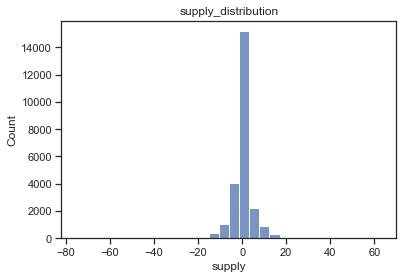

In [287]:
sns.histplot(data = supply_df.supply, bins=30).set_title("supply_distribution")
plt.savefig("output/supply_distribution.jpg")

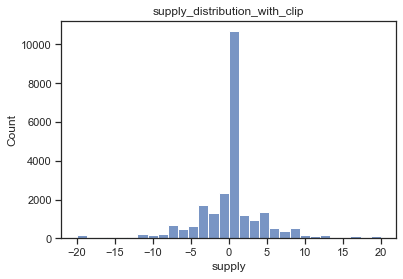

In [288]:
sns.histplot(data = supply_df.supply.clip(-20, 20), bins=30).set_title("supply_distribution_with_clip")
plt.savefig("output/supply_distribution_with_clip.jpg")

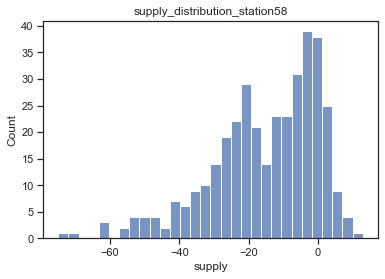

In [289]:
sns.histplot(data = supply_df[supply_df.station_id == 58].supply, bins=30).set_title("supply_distribution_station58")
plt.savefig("output/supply_distribution_station58.jpg")

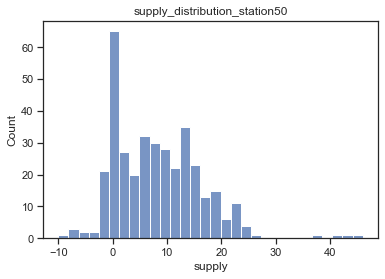

In [290]:
sns.histplot(data = supply_df[supply_df.station_id == 50].supply,
             bins=30).set_title("supply_distribution_station50")
plt.savefig("output/supply_distribution_station50.jpg")

In [291]:
_ind = supply_df.supply > 20
supply_df[_ind].sort_values("date").head(10)

,date,supply,station_id
3440,2013-10-24,21.0,50
3945,2013-11-01,22.0,43
4272,2013-11-06,23.0,50
4400,2013-11-08,22.0,50
4852,2013-11-15,23.0,54
5552,2013-11-26,22.0,50
6843,2013-12-16,21.0,61
7024,2013-12-19,23.0,50
7152,2013-12-21,21.0,50
7992,2014-01-03,23.0,50


In [292]:
supply_df[supply_df.station_id == 58].tail(10)

,date,supply,station_id
24004,2014-08-22,-52.0,58
24074,2014-08-23,-3.0,58
24144,2014-08-24,2.0,58
24214,2014-08-25,-75.0,58
24284,2014-08-26,-55.0,58
24354,2014-08-27,-48.0,58
24424,2014-08-28,-63.0,58
24494,2014-08-29,-45.0,58
24564,2014-08-30,2.0,58
24634,2014-08-31,-7.0,58


In [293]:
_ind = (status_df.date < "2014-9") & (status_df.station_id == 58) & (status_df.date >= "2014-8") 
status_df[_ind]

,id,year,month,day,hour,station_id,bikes_available,predict,date
1024176,1024176,2014,8,1,0,58,12.0,0,2014-08-01
1024177,1024177,2014,8,1,1,58,13.0,0,2014-08-01
1024178,1024178,2014,8,1,2,58,13.0,0,2014-08-01
1024179,1024179,2014,8,1,3,58,13.0,0,2014-08-01
1024180,1024180,2014,8,1,4,58,13.0,0,2014-08-01
...,...,...,...,...,...,...,...,...,...
1024915,1024915,2014,8,31,19,58,12.0,0,2014-08-31
1024916,1024916,2014,8,31,20,58,12.0,0,2014-08-31
1024917,1024917,2014,8,31,21,58,11.0,0,2014-08-31
1024918,1024918,2014,8,31,22,58,11.0,0,2014-08-31


In [294]:
time_split =  "2014-07"
train_index = supply_df["date"] < time_split
test_index = supply_df["date"] >= time_split

x_train = feat_train_df[train_index]
y_train = supply_df.supply.values[train_index]

x_test = feat_train_df[test_index]
y_test = supply_df.supply.values[test_index]

/home/dito/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/dito/.pyenv/versions/3.6.7/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [312]:
LGBM_DEFAULT_PARAMS = {
    #"objective": 'multiclass',
    'learning_rate': 0.1, 
    'max_depth': 3,
    "num_leaves": 8,
    "colsample_bytree": .7,
    'n_estimators': 200,
    'importance_type': 'gain' ,
    #"class_weight":"balanced",
    #"objective": "huber"
}

model = lgbm.LGBMRegressor(**LGBM_DEFAULT_PARAMS)
model.fit(x_train, y_train)
pred_i = model.predict(x_test)

print(f'rmse: {np.sqrt(mean_squared_error(y_test, pred_i)):.6f}')
print(f'rmse: {np.sqrt(mean_squared_error(y_test, np.zeros(y_test.shape))):.6f}')
print(f'rmse: {np.sqrt(mean_squared_error(y_test, np.full(y_test.shape, np.mean(y_train)))):.6f}')


rmse: 7.652595
rmse: 7.656553
rmse: 7.656553


save to output/supply_importance.png


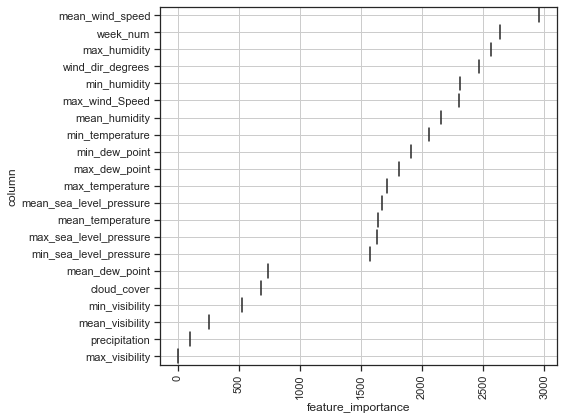

In [305]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:100]
    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', 
                  orient='h',
                  order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax
fig, ax = visualize_importance([model], feat_train_df)
savefig(fig, to=f'supply_importance')


In [314]:
out = pd.DataFrame()
out["date"] = supply_df.loc[test_index, "date"]
out["pred"] = pred_i
out["gt"] = y_test
out.head(30)

,date,pred,gt
20306,2014-07-01,-0.190879,-8.0
20376,2014-07-02,-0.522068,1.0
20446,2014-07-03,0.273291,0.0
20516,2014-07-04,-0.192776,0.0
20586,2014-07-05,0.457606,5.0
20656,2014-07-06,0.443607,2.0
20726,2014-07-07,0.394780,2.0
20796,2014-07-08,0.340062,-5.0
20866,2014-07-09,0.093301,0.0
20936,2014-07-10,-0.194226,0.0


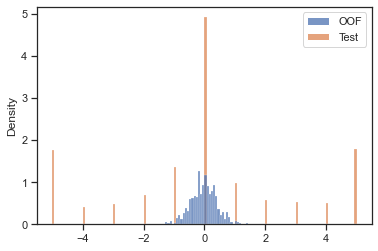

In [316]:
sns.histplot(data=pd.DataFrame({
            'OOF': out.pred,
            'Test': np.clip(y_test, -5, 5)}), stat='density', common_norm=False,)
plt.savefig("output/supply_oof_test.jpg")